Author: Annelise Lynch

# Motivation

Customer churn and customer conversions are two very common metrics in product analysis. Typically, a very low percentage of traffic or interest actually results in a conversion (purchase of a product). In the case of subscriptions or SaaS (Software as a Service), customer churn is another important metric. This is the percentage of customers that cancel their subscription or auto-renewal of a product.

Customer churn data may take into account how a user interacts with a product and how frequenty. It also may track characteristics of a user or company. 

Since this data is always very unbalanced (low churn <10%) it makes data modeling tricky! This notebook uses a sampled subset of 1 month of Kaggle user data to learn and predict customer churn for a music subscription service. The total data set is 6 months, however more computing power and memory is required to import and process the entire dataset.

## Dataset and description: 
Details and data available for download: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/notebooks?sortBy=hotness&group=everyone&pageSize=20&competitionId=7163&language=Python

In this challenge, you are asked to predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

The key fields to determine churn/renewal are transaction date, membership expiration date, and is_cancel. Note that the is_cancel field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

#### Predictor:
`is_churn`: Churn is defined as whether the user did not continue the subscription within 30 days of expiration. `is_churn` = 1 means churn, `is_churn` = 0 means renewal.

#### Features:
- `payment_method_id`: payment method
- `payment_plan_days`: length of membership plan in days
- `plan_list_price`: in New Taiwan Dollar (NTD)
- `actual_amount_paid`: in New Taiwan Dollar (NTD)
- `is_auto_renew`
- `transaction_date`: format %Y%m%d
`membership_expire_date`: format %Y%m%d
- `is_cancel`: whether or not the user canceled the membership in this transaction.
- `user_log_date`: format %Y%m%d
- `num_25`: # of songs played less than 25% of the song length
- `num_50`: # of songs played between 25% to 50% of the song length
- `num_75`: # of songs played between 50% to 75% of of the song length
- `num_985`: # of songs played between 75% to 98.5% of the song length
- `num_100`: # of songs played over 98.5% of the song length
- `num_unq`: # of unique songs played
- `total_secs`: total seconds played
- `city`
- `bd`: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
- `gender`
- `registered_via`: registration method
- `registration_init_time`: format %Y%m%d
- `expiration_date`: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

#### ID Field:
`msno`: user id

#### Other notes:
The _v2_ data was used for this notebook because the original/v1 data was extremely large and yielded memory problems. There were memory reduction techniques on Kaggle, but for the scope and time of this project, that was not tackled.

# Methodology

## Feature engineering
- Computer not robust enough to load all of the data, used only 1 month of data (from the 6 provided), and sub-sampled from that as well.
- Non-cateogrical features: fit with StandardScalar
- Categorical features: one hot encoding
- Made new features using date, like `days to expiration`.

## Unbalanced data - oversampling
- Used imblearn `RandomOverSampler` to increase the training ratio of churn from ~10% to 50%. 
- Chose oversampling instead of undersampling due to having already limited the data.

## RNN - shaping the data
- Assume 1000 users, 1 month of data with daily logs, and 25 features
<center>
<img src="img\time_series.png" width="50%">
</center>
- This means, to format the data properly for an RNN, it needs to be in the following format:
```(1000,25,31)```
- Tricky bits to get this completed:
    - not every user has an activity log on a given day, had to "pad" this
    - the data was provided in flat files, in order to achieve 3 dimensions, a for loop was necessary
    
This means, turning this table:

user_id | log_date | features | is_churn
---| -----| -----| --
1 | 3/1/2017 | features | 0
1 | 3/3/2017 | features | 0
1 | 3/15/2017 | features | 0
1 | 3/28/2017 | features | 0
2 | 3/5/2017 | features | 1
2 | 3/15/2017 | features | 1

Into this table:

user_id | log_date | features | is_churn
---| -----| -----| --
1 | 3/1/2017 | features | 0
1 | 3/2/2017 | features | 0
1 | ... | features | 0
1 | ... | features | 0
1 | ... | features | 0
1 | 3/31/2017 | features | 0
2 | 3/1/2017 | features | 1
2 | ... | features | 1
2 | ... | features | 1
2 | ... | features | 1
2 | 3/31/2017 | features | 1

And then finally into the 3 dimensional table with the dimensions:

`(number of user ids, number of features, 31 (days))`


## Feature pruning
- Principle Component Analysis (PCA)
- Incoporated PCA results prior to LSTM model!


## Future work
- More robust hardware to handle the memory and computing power required to process the entire datset.
- Fine tune the correct number of time-steps to look back at. Currently using 30 days because that is the maximum available while processing this dataset on a laptop.
- Test this model and method on customer churn data from a different company. And test this model and method on customer conversion data.

# Takeaways
This was a fantastic project to fine tune how to handle unbalanced datasets and correctly process time-series data into the RNN 3-dimensional shape. Overall the final accuracy of the test data at 96% beat the (1-churn) percentage of 93% so this was an absolute success. This model will be useful to share with companies who are looking for insights into what factors contribute to churn, and, perhaps more importantly, what factors make their product sticky and prevent churn!

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import pickle
import gc; gc.enable()
from time import time
from datetime import datetime, timedelta, date
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from imblearn.over_sampling import  RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, Bidirectional, Flatten, Embedding, GRU
from keras import regularizers
from keras.utils import to_categorical

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


# Loading in the data
### Note: using limited data set and a heavy use of left joins to ensure limited data is used

In [2]:
# Load in data
train = pd.read_csv('data/kkbox-churn-prediction-challenge/train_v2.csv')

train = train.sample(10000)
train_ids = train
print(len(train))
print(train.head())
print(train.tail())

10000
                                                msno  is_churn
755516  9f0+9F6rZzU3jMjS4VU23N2MCk08MTkab6AGGsggfaw=         0
719432  BvhlhkqythELhVLYxPtSXtqbWSLyWvOOz5Etzj5U35M=         0
188548  cuq1z1n2PyxjFMN/rUmzVtH0FHJG9mA9w3fafa5yFPM=         0
941582  uDpf6VyX3bAOqvO8sWGAz73gWzZekbMDus7gL20d4Js=         0
870351  Tr3sWIgrzHL+zTvBTDptJUlMJXmfV1hKEtECHSwt4jI=         0
                                                msno  is_churn
489375  2boH7TuYkD69efoN6QmQY2rU5E9IlYrtJ+OQzEPvdXg=         0
12374   pdt6q2b+XrtMdXKtD68lJbcOUzrTLgyknGuzdxsnExo=         1
287293  lIWXzze902yO2b5XQWGQ6R7N3XLkEnPYf6pb/0c/RTQ=         0
287523  KfftirQXJNyRDxFTZyZhkqB02FoOZZjJCiuZntAdVUU=         0
432206  sjlgx8JKCP0Ee3dQUhahRem5Wez0JrbnDKxmNNsJcxc=         0


In [3]:
# members
members = pd.read_csv('data/kkbox-churn-prediction-challenge/members_v3.csv')
train = train.merge(members, on = 'msno', how = 'left')

transactions = pd.read_csv('data/kkbox-churn-prediction-challenge/transactions_v2.csv') 
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

train = pd.merge(train, transactions, how='left', on='msno')
transactions=[]

print(train.keys())
print(train.head())

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel'],
      dtype='object')
                                           msno  is_churn  city    bd  gender  \
0  9f0+9F6rZzU3jMjS4VU23N2MCk08MTkab6AGGsggfaw=         0  22.0  29.0  female   
1  BvhlhkqythELhVLYxPtSXtqbWSLyWvOOz5Etzj5U35M=         0  22.0  27.0  female   
2  cuq1z1n2PyxjFMN/rUmzVtH0FHJG9mA9w3fafa5yFPM=         0   5.0  33.0  female   
3  uDpf6VyX3bAOqvO8sWGAz73gWzZekbMDus7gL20d4Js=         0  13.0  19.0    male   
4  Tr3sWIgrzHL+zTvBTDptJUlMJXmfV1hKEtECHSwt4jI=         0  13.0  35.0    male   

   registered_via  registration_init_time  payment_method_id  \
0             3.0              20120606.0               39.0   
1             9.0              20100309.0               40.0   
2             9.0      

In [4]:
# make some handy sorting functions
def transform_df_sort_msno_date(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['msno','date'], ascending=[True,True])
    df = df.reset_index(drop=True)
    return df

def transform_df_sort_msno(df):
    df = df.sort_values(by=['msno'], ascending=[True])
    df = df.reset_index(drop=True)
    return df

In [5]:
# Get user log data
last_user_logs = []
last_user_logs.append(transform_df_sort_msno_date(pd.read_csv('data/kkbox-churn-prediction-challenge/user_logs_v2.csv')))
last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df_sort_msno_date(last_user_logs)

print ('merging user logs features...')
train = pd.merge(train, last_user_logs, how='left', on='msno')

train = transform_df_sort_msno_date(train)

print ('done...')

print(train.head())

merging user logs features...
done...
                                           msno  is_churn  city   bd gender  \
0  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0   1.0  0.0    NaN   
1  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0   1.0  0.0    NaN   
2  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0   1.0  0.0    NaN   
3  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0   1.0  0.0    NaN   
4  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0   1.0  0.0    NaN   

   registered_via  registration_init_time  payment_method_id  \
0             9.0              20140907.0               28.0   
1             9.0              20140907.0               28.0   
2             9.0              20140907.0               28.0   
3             9.0              20140907.0               28.0   
4             9.0              20140907.0               28.0   

   payment_plan_days  plan_list_price  ...  membership_expire_date  is_cancel  \
0               30.0 

In [6]:
train.shape

(140169, 23)

### Feature Engineering
#### Standardizing features
#### One hot encoding
#### Filling in n/as

In [7]:
# Create standardized features
def standardize_features(df):
    df['mem_exp_date'] =  pd.to_datetime(df['membership_expire_date'], format='%Y%m%d')
    df['date']=  pd.to_datetime(df['date'], format='%Y%m%d')
    df['discount'] = df['plan_list_price'] - df['actual_amount_paid']
    df['days_to_expire'] = df['date'] - df['mem_exp_date']

    normalize_features = ['actual_amount_paid', 'plan_list_price','bd', 'discount','days_to_expire','num_25','num_50','num_75','num_985','num_100','num_unq','total_secs','payment_plan_days']
    for feature in normalize_features: 
        df[feature] = StandardScaler().fit_transform(df[feature].values.reshape(-1, 1))

    return df

train = standardize_features(train)

In [8]:
# One hot encoding features

def one_hot_encoding(df):
    one_hot_encoding_features = ['is_auto_renew', 'is_cancel', 'city','gender','registered_via','payment_method_id']

    for feature in one_hot_encoding_features: 
        df[feature] = df[feature].astype('category')
        df = pd.get_dummies(df, columns=[feature], dummy_na=True,drop_first=True)
    
    return df

train = one_hot_encoding(train)

In [9]:
# fill nas
train[train==np.inf]=np.nan
train.fillna(train.mean(), inplace=True)
# train.fillna(0, inplace=True)
print(train.head())

                                           msno  is_churn        bd  \
0  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0 -0.530089   
1  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0 -0.530089   
2  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0 -0.530089   
3  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0 -0.530089   
4  ++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=         0 -0.530089   

   registration_init_time  payment_plan_days  plan_list_price  \
0              20140907.0          -0.152187        -0.069324   
1              20140907.0          -0.152187        -0.069324   
2              20140907.0          -0.152187        -0.069324   
3              20140907.0          -0.152187        -0.069324   
4              20140907.0          -0.152187        -0.069324   

   actual_amount_paid  transaction_date  membership_expire_date       date  \
0           -0.067273        20170314.0              20170419.0 2017-03-01   
1           -0.067273     

# Split into train/test and perform 50% oversampling

In [10]:

#sort
train = transform_df_sort_msno_date(train)
save_train = train

# Split into train/test by msno id
train_id = pd.DataFrame(train_ids['msno'])
response = pd.Series(train_ids['is_churn'].values).astype('int32')

X_train, X_test, y_train, y_test = train_test_split(train_id, response, test_size = 0.2, random_state=123)
print('Original Sample {}'.format(Counter(y_train)))

# Over sample
sampler = RandomOverSampler(random_state=123, sampling_strategy=0.50)
X_train_oversample, y_train = sampler.fit_resample(X_train, y_train)
X_test_keep = X_test
print('RandomOverSampler {}'.format(Counter(y_train)))

print(y_train)

Original Sample Counter({0: 7257, 1: 743})
RandomOverSampler Counter({0: 7257, 1: 3628})
[0 0 1 ... 1 1 1]


In [11]:
# Left join data back in
X_train = pd.merge(X_train, train, how='left', on='msno')
X_test = pd.merge(X_test, train, how='left', on='msno')

print("Train churn ratio", len(X_train[X_train['is_churn'] == 1])/len(X_train))
print("Test churn ratio", len(X_test[X_test['is_churn'] == 1])/len(X_test))

print("Train churn ratio", len(y_train[y_train == 1])/len(y_train))
print("Test churn ratio", len(y_test[y_test == 1])/len(y_test))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Train churn ratio 0.08160299558685864
Test churn ratio 0.08259534352235395
Train churn ratio 0.33330271015158475
Test churn ratio 0.0985
(112165, 80)
(28004, 80)
(10885,)
(2000,)


# Fill in missing dates for RNN cube prep

In [12]:
def populate_dates(df, msno_df=pd.DataFrame()):
    train_pop = df
    train_pop['log_date'] =  pd.to_datetime(train_pop['date'])

    train_test_date = pd.DataFrame()
    train_test_date['log_date'] = train_pop['log_date'].unique()
    train_test_date['id'] =1

    print(len(train_test_date))

    print(len(df))
    train_test_msno = pd.DataFrame()
    if len(msno_df)>1:
        train_test_msno['msno'] = msno_df['msno']
    else:
        train_test_msno['msno'] = df['msno']
    train_test_msno['id'] = 1
    print(len(train_test_msno))

    print(len(last_user_logs))

    train_full_populate = pd.merge(train_test_msno, train_test_date, how='outer', on='id')
    print(len(train_full_populate))

    df['date'] = pd.to_datetime(df['date'])
    train_full_populate['date'] = train_full_populate['log_date']

    df = pd.merge(train_full_populate, df, how='left', on=['msno','date'])
    print(df.head())
    return df

X_train = populate_dates(X_train, X_train_oversample)
X_test = populate_dates(X_test, X_test_keep)

32
112165
10885
18396362
348320
                                           msno  id log_date_x       date  \
0  hV89+R/U2LNJ8lxdzieHp+FUpTaEEZh80/T+QCITQpQ=   1 2017-03-13 2017-03-13   
1  hV89+R/U2LNJ8lxdzieHp+FUpTaEEZh80/T+QCITQpQ=   1 2017-03-19 2017-03-19   
2  hV89+R/U2LNJ8lxdzieHp+FUpTaEEZh80/T+QCITQpQ=   1 2017-03-04 2017-03-04   
3  hV89+R/U2LNJ8lxdzieHp+FUpTaEEZh80/T+QCITQpQ=   1 2017-03-14 2017-03-14   
4  hV89+R/U2LNJ8lxdzieHp+FUpTaEEZh80/T+QCITQpQ=   1 2017-03-16 2017-03-16   

   is_churn       bd  registration_init_time  payment_plan_days  \
0       0.0  0.97996              20051025.0          -0.152187   
1       0.0  0.97996              20051025.0          -0.152187   
2       NaN      NaN                     NaN                NaN   
3       NaN      NaN                     NaN                NaN   
4       NaN      NaN                     NaN                NaN   

   plan_list_price  actual_amount_paid  ...  payment_method_id_34.0  \
0        -0.074772           -0

In [13]:
# make non-rnn data
X_train_reg = X_train
X_test_reg = X_test

In [14]:
# fill in NaNs and infinite values
X_train_reg[X_train_reg==np.inf]=np.nan
X_train_reg.fillna(X_train_reg.mean(), inplace=True)

X_test_reg[X_test_reg==np.inf]=np.nan
X_test_reg.fillna(X_test_reg.mean(), inplace=True)

print(X_test.shape)
print(X_train.shape)

y_train_reg = pd.Series(X_train_reg['is_churn'].values).astype('int32')
y_test_reg = pd.Series(X_test_reg['is_churn'].values).astype('int32')


(64000, 83)
(348320, 83)


In [15]:
def clean_up(df):
    remove_columns = ['log_date_x', 
                      'log_date_y', 
                      'id', 
                      'is_churn', 
                      'msno',
                      'date',
                      'transaction_date',
                      'membership_expire_date',
                      'mem_exp_date']
    for column in remove_columns:
        try:
            df.pop(column)
        except(KeyError):
            next

    return df

X_train = clean_up(X_train)
X_test = clean_up(X_test)
X_train_reg = clean_up(X_train_reg)
X_test_reg = clean_up(X_test_reg)

# Format data for RNN into shape (examples, features, time_steps)

In [16]:
print("Train churn ratio", len(y_train[y_train == 1])/len(y_train))
print("Test churn ratio", len(y_test[y_test == 1])/len(y_test))

Train churn ratio 0.33330271015158475
Test churn ratio 0.0985


In [17]:
# Format the data for RNN

def reshape_for_rnn(df, oversample_size=pd.DataFrame()):
    if len(oversample_size)>1:
        n_rows = len(oversample_size)
    else:
        n_rows = len(df)
    n_features = df.shape[1]
    n_dates = 32

    features = df.keys()
    features_tuple_train = []
    for feature in features:
        features_tuple_train.append([df[feature].values.reshape((n_rows,n_dates))])

    features_tuple_train = tuple(features_tuple_train)

    print("made tuple")

    df = np.hstack(
        features_tuple_train
    ).reshape(n_rows, n_features, n_dates).transpose(0, 1, 2)
    
    return df


X_train = reshape_for_rnn(X_train, X_train_oversample)
X_test = reshape_for_rnn(X_test, X_test_keep)

made tuple
made tuple


In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10885, 74, 32)
(2000, 74, 32)
(10885,)
(2000,)


# Model development

In [19]:
print((X_train.shape[0],X_train.shape[1],X_train.shape[2]))
# Make a simple model:
model =Sequential()
model.add(LSTM(
  units=32,input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dense(units=20))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Dense(units=1))
model.add(Activation('softmax'))
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    verbose=1
)

model.summary()

print(history)

(10885, 74, 32)
Epoch 1/5
10885/10885 [==============================] - 13s 1ms/step - loss: 10.2226 - accuracy: 0.3333
Epoch 2/5
10885/10885 [==============================] - 13s 1ms/step - loss: 10.2226 - accuracy: 0.3333
Epoch 3/5
10885/10885 [==============================] - 14s 1ms/step - loss: 10.2226 - accuracy: 0.3333
Epoch 4/5
10885/10885 [==============================] - 16s 2ms/step - loss: 10.2226 - accuracy: 0.3333
Epoch 5/5
10885/10885 [==============================] - 13s 1ms/step - loss: 10.2226 - accuracy: 0.3333
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)  

In [20]:
def report_results(model, X, y):
    pred = model.predict_classes(X)    
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    cm = confusion_matrix(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec, 'confusion_matrix': cm}
    return result

{'f1': 0.17933545744196633, 'acc': 0.0985, 'precision': 0.0985, 'recall': 1.0, 'confusion_matrix': array([[   0, 1803],
       [   0,  197]])}


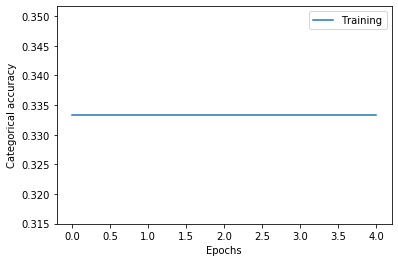

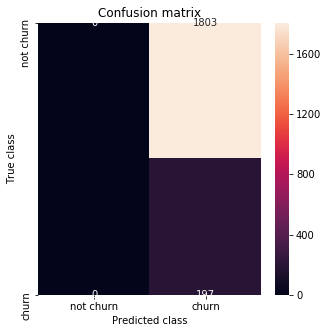

In [22]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [23]:
# Way too many epochs, started at 30 and reduced to 5
# Changing to Bidirections Simple RNN
model =Sequential()
model.add(Bidirectional(SimpleRNN(32, return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units=16))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Flatten())
model.add(Dense(units=1))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

print(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 74, 64)            4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 64)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 74, 16)            1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 74, 16)            64        
_________________________________________________________________
activation_3 (Activation)    (None, 74, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1184)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [24]:
def report_results(model, X, y):
    pred = model.predict_classes(X)    
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    cm = confusion_matrix(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec, 'confusion_matrix': cm}
    return result

{'f1': 0.0, 'acc': 0.9, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[1800,    3],
       [ 197,    0]])}


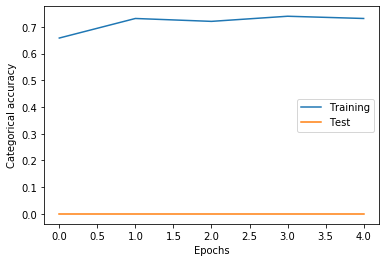

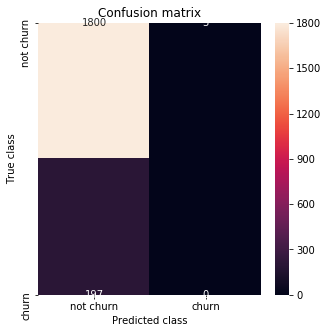

In [25]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [26]:
# Using the tips for vanishing/exploding gradients from this blog: https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/
# Using GRU instead of LSTM per the blog recommendations
# Computationally more expensive but better for POCs like this
model=Sequential()
# model.add(Embedding(input_dim=1000, output_dim=128))
model.add(GRU(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()



history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    verbose=1
)
model.summary()

print(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10885/10885 [==============================] - 7s 623us/step - loss: 0.6465 - accuracy: 0.6488
Epoch 2/5
10885/10885 [==============================] - 6s 584us/step - loss: 0.6193 - accuracy: 0.6665
Epoch 3/5
10885/10885 [==============================] - 6s 586us/step - loss: 0.6087 - accuracy: 0.6665
Epoch 4/5
10885/10885 [==============================] - 6s 577us

{'f1': 0.08645533141210375, 'acc': 0.8415, 'precision': 0.1, 'recall': 0.07614213197969544, 'confusion_matrix': array([[1668,  135],
       [ 182,   15]])}


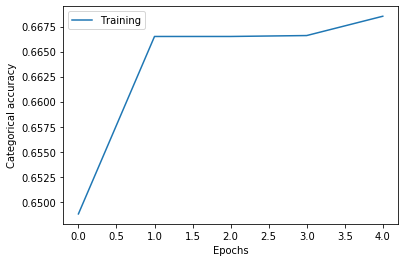

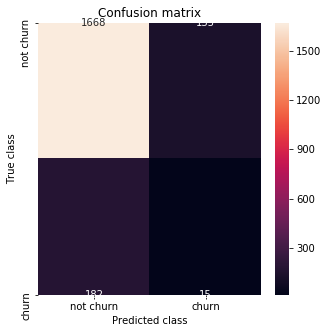

In [27]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [28]:
# Increasing the batch size after watching the accuracy decrease rapidly during an epoch
# Using the tips for vanishing/exploding gradients from this blog: https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/
# Using GRU instead of LSTM per the blog recommendations
# Computationally more expensive but better for POCs like this
model=Sequential()
# model.add(Embedding(input_dim=1000, output_dim=128))
model.add(GRU(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

print(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________
Train on 9796 samples, validate on 1089 samples
Epoch 1/50
9796/9796 [==============================] - 7s 739us/step - loss: 0.5981 - accuracy: 0.7047 - val_loss: 1.6766 - val_accuracy: 0.0000e+00
Epoch 2/50
9796/9796 [==============================] - 6s 593us/step - loss: 0.5518 - accuracy: 0.7407 - val_loss: 1.6847 - val_accuracy: 0.0000e+00
Epoch 3/50
9796/9796 [==========

{'f1': 0.02247191011235955, 'acc': 0.8695, 'precision': 0.04285714285714286, 'recall': 0.015228426395939087, 'confusion_matrix': array([[1736,   67],
       [ 194,    3]])}


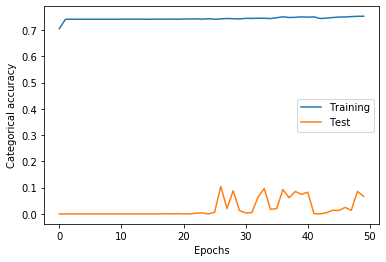

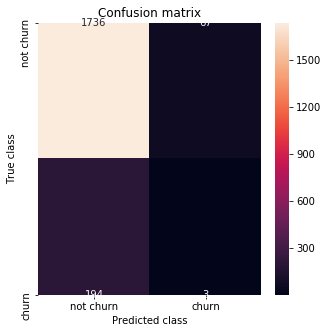

In [29]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [30]:
# Model 2, adding SimpleRNN, GRU, or LSTM to the best model found here: https://www.kaggle.com/ripcurl/feedforward-neural-network-0-12174
lsize = 128
model = Sequential()
# model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_train.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=1026,
                    validation_split=0.2, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.0, 'acc': 0.9015, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[1803,    0],
       [ 197,    0]])}


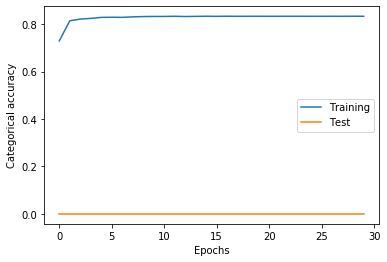

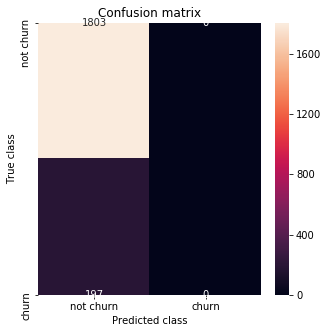

In [31]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Epoch 1/5
10885/10885 [==============================] - 2s 141us/step - loss: 1.2897 - accuracy: 0.6649
Epoch 2/5
10885/10885 [==============================] - 1s 100us/step - loss: 1.0746 - accuracy: 0.6558
Epoch 3/5
10885/10885 [==============================] - 1s 124us/step - loss: 0.9945 - accuracy: 0.6440
Epoch 4/5
10885/10885 [==============================] - 2s 146us/step - loss: 0.9405 - accuracy: 0.6352
Epoch 5/5
10885/10885 [==============================] - 2s 185us/step - loss: 0.8959 - accuracy: 0.6341
{'f1': 0.0404040404040404, 'acc': 0.8575, 'precision': 0.06, 'recall': 0.030456852791878174, 'confusion_matrix': array([[1709,   94],
       [ 191,    6]])}


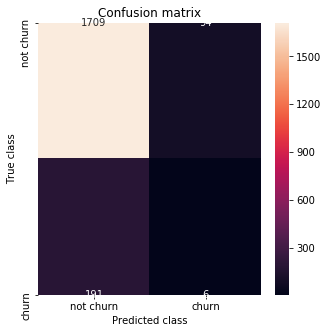

In [32]:
simple_lstm_model = Sequential([
    LSTM(8, input_shape=X_train.shape[-2:]),
    Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = simple_lstm_model.fit(X_train, y_train, epochs=5, batch_size=2000, verbose=1)

test_results = report_results(simple_lstm_model, X_test, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = simple_lstm_model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Feature pruning using PCA

In [ ]:
# X_train_reg[X_train_reg==np.inf]=np.nan
# X_train_reg.fillna(X_train_reg.mean(), inplace=True)

# X_test_reg[X_test_reg==np.inf]=np.nan
# X_test_reg.fillna(X_test_reg.mean(), inplace=True)

(348320, 74)
(348320, 15)


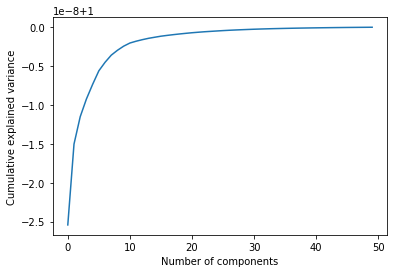

In [33]:
#PCA

pca = PCA(n_components=50)
pca.fit(X_train_reg)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

NCOMPONENTS = 15

pca = PCA(n_components=NCOMPONENTS, svd_solver='full')
X_pca_train = pca.fit_transform(X_train_reg)
X_pca_test = pca.transform(X_test_reg)
pca_std = np.std(X_pca_train)

print(X_train_reg.shape)
print(X_pca_train.shape)

In [34]:
# Use PCA
print(y_train_reg.head())
lsize = 128
model = Sequential()
model.add(Dense(lsize, input_dim=int(X_pca_train.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_pca_train, y_train_reg, epochs=10, batch_size=1026,
                    validation_split=0.2, verbose=1)

# X_pca_test

0    0
1    0
2    0
3    0
4    0
dtype: int32
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_

{'f1': 0.0, 'acc': 0.963859375, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[61687,     0],
       [ 2313,     0]])}


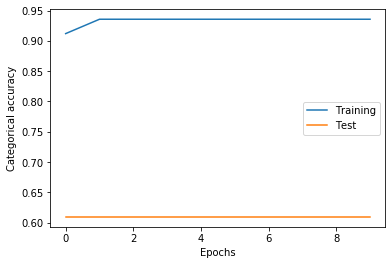

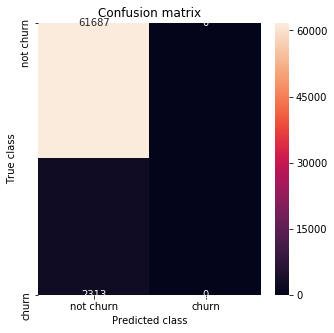

In [36]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_pca_test, y_test_reg)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_pca_test)
conf_matrix = confusion_matrix(y_test_reg, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [37]:
print(pca.components_)
print(pca.explained_variance_)

[[ 8.16910449e-06 -1.00000000e+00 -1.61975456e-07 ...  1.25666702e-06
  -4.32156996e-06 -2.10430362e-07]
 [ 3.39412510e-02  2.27392893e-06  5.70033577e-01 ... -7.47569456e-03
  -4.28990945e-02 -4.64077553e-03]
 [ 1.58069940e-02  1.51445172e-06 -2.11835544e-02 ...  2.50364146e-03
  -1.35980008e-02 -1.42858041e-03]
 ...
 [-2.98547051e-03  6.26319882e-08  4.21590558e-03 ... -1.15418265e-02
   1.32333946e-02  3.52789972e-03]
 [ 4.22949132e-02 -5.07286801e-06 -7.91462900e-03 ... -3.01363543e-01
   9.90610126e-02  2.43314817e-02]
 [ 4.23209635e-03 -1.29737489e-06 -8.04221780e-02 ...  6.59313793e-02
  -1.06931564e-01 -1.41943098e-02]]
[3.89678315e+08 4.04698504e+00 1.36941585e+00 8.87005211e-01
 7.33495129e-01 6.76878150e-01 4.26241986e-01 3.57863495e-01
 2.44270958e-01 2.05875935e-01 1.56445182e-01 9.09658640e-02
 7.68608702e-02 6.80580352e-02 5.39313553e-02]


(348320,)
(348320,)


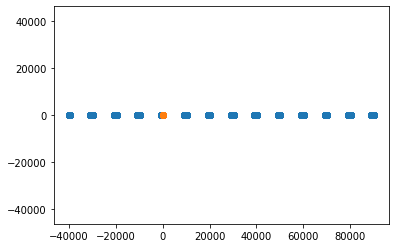

In [45]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
print(X_pca_train[:, 0].shape)
print(y_train_reg.shape)

X_new = pca.inverse_transform(X_pca_train)
plt.scatter(X_pca_train[:, 0], y_train_reg, alpha=0.2)
plt.scatter(X_new[:, 0], y_train_reg, alpha=0.8)
plt.axis('equal');

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


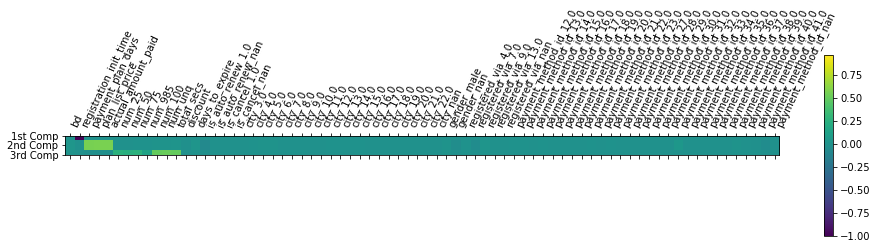

In [61]:
# Interpret PCA
feature_col_names = X_train_reg.columns.values
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(feature_col_names)),feature_col_names,rotation=65,ha='left')
plt.tight_layout()
plt.show()# 

# Use PCA output to determine RNN features

In [77]:
# Using the above PCA output, use only the most valuable features:
columns_to_keep = ['bd',
                   'registration_init_time',
                   'payment_plan_days',
                   'plan_list_price',
                   'actual_amount_paid',
                   'num_25',
                   'num_50',
                   'num_75',
                   'num_985',
                   'num_100',
                   'num_unq',
                   'total_secs',
                   'discount',
                   'days_to_expire',
                   'is_auto_renew_1.0']

X_train_pca_rnn = X_train_reg
y_train_pca_rnn = y_train_reg
X_test_pca_rnn = X_test_reg
y_test_pca_rnn = y_test_reg

print(X_train_reg.shape)

(348320, 74)


In [78]:
# Remove all columns from X_train and X_test except for PCA identified columns above:
X_train_pca_rnn = X_train_pca_rnn[columns_to_keep]
X_test_pca_rnn = X_test_pca_rnn[columns_to_keep]
print(X_train_pca_rnn.shape)
print(X_test_pca_rnn.shape)
# Format the data for RNN
def reshape_for_rnn(df, oversample_size=pd.DataFrame()):
    if len(oversample_size)>1:
        n_rows = len(oversample_size)
    else:
        n_rows = len(df)
    n_features = df.shape[1]
    n_dates = 32

    features = df.keys()
    features_tuple_train = []
    for feature in features:
        features_tuple_train.append([df[feature].values.reshape((n_rows,n_dates))])

    features_tuple_train = tuple(features_tuple_train)

    print("made tuple")

    df = np.hstack(
        features_tuple_train
    ).reshape(n_rows, n_features, n_dates).transpose(0, 1, 2)
    
    return df


X_train_pca_rnn = reshape_for_rnn(X_train_pca_rnn, X_train_oversample)
X_test_pca_rnn = reshape_for_rnn(X_test_pca_rnn, X_test_keep)

print(X_train_pca_rnn.shape)
print(X_test_pca_rnn.shape)

(348320, 15)
(64000, 15)
made tuple
made tuple
(10885, 15, 32)
(2000, 15, 32)


In [83]:
# Model 2, adding SimpleRNN, GRU, or LSTM to the best model found here: https://www.kaggle.com/ripcurl/feedforward-neural-network-0-12174
lsize = 128
model = Sequential()
model.add(Dropout(rate=0.1))
# model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(
  units=128,
  input_shape=(X_train_pca_rnn.shape[1], X_train_pca_rnn.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_train_pca_rnn.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# model.summary()

# Fit the model
history = model.fit(X_train_pca_rnn, y_train, epochs=15, batch_size=1026,
                    validation_split=0.2, verbose=1)

Train on 8708 samples, validate on 2177 samples
Epoch 1/15
8708/8708 [==============================] - 5s 549us/step - loss: 4.7563 - accuracy: 0.5264 - val_loss: 4.4240 - val_accuracy: 0.0124
Epoch 2/15
8708/8708 [==============================] - 4s 458us/step - loss: 3.9545 - accuracy: 0.7472 - val_loss: 3.9798 - val_accuracy: 9.1870e-04
Epoch 3/15
8708/8708 [==============================] - 4s 512us/step - loss: 3.4034 - accuracy: 0.8000 - val_loss: 3.5889 - val_accuracy: 0.0000e+00
Epoch 4/15
8708/8708 [==============================] - 5s 540us/step - loss: 2.9717 - accuracy: 0.8075 - val_loss: 3.2342 - val_accuracy: 0.0000e+00
Epoch 5/15
8708/8708 [==============================] - 4s 506us/step - loss: 2.6069 - accuracy: 0.8118 - val_loss: 2.9315 - val_accuracy: 0.0000e+00
Epoch 6/15
8708/8708 [==============================] - 3s 401us/step - loss: 2.2985 - accuracy: 0.8169 - val_loss: 2.6701 - val_accuracy: 0.0000e+00
Epoch 7/15
8708/8708 [==============================] - 

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.0, 'acc': 0.9015, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[1803,    0],
       [ 197,    0]])}


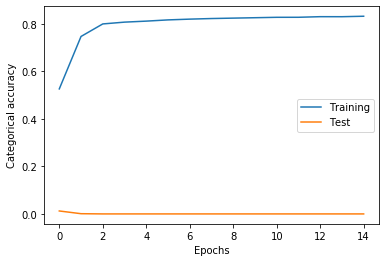

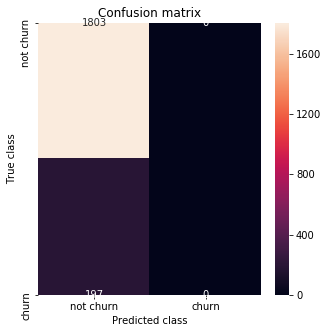

In [84]:
# Plot and predict
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test_pca_rnn, y_test)
print(test_results)

LABELS = ['not churn', 'churn']
y_pred = model.predict_classes(X_test_pca_rnn)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()